# Grammianos ponderados entre subespacios ligand-free (lf), ligand-bound (lb) y subespacios de la dinámica de no equilibrio

In [1]:
using DataFrames
using Gadfly
using Cairo
set_default_plot_size(40cm, 14cm)

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function read_ptraj_modes(file, modes_elements, nmodes::Int64=0, norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    comments=true, comment_char='\*')
    close(modes_file)

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 3 methods)

In [4]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [34]:
function grammian(mtx_1, mtx_2)
    # Projects mtx_1 onto mtx_2    
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    mtx_p = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
    mtx_g = transpose(mtx_p) * mtx_p
    
    zeta = mean(diag(mtx_g))
    
    return zeta
end

grammian (generic function with 1 method)

### Hago

In [20]:
# Preparo variables
aa = 101
aa3 = aa * 3
aa3_6 = aa3 - 6
n_frames = 400
main_dir = "/home/german/labo/16/pdz_gramm/"
LfLb_dir = "analyze_qha_ca/"
neq_dir = "lb_dats/"
neq_modes_dir = "vecs/"

neq_pond_template = "-lbnoteq_ca_mode_freq_nohist.dat"       # ej: "1" * neq_pond_template
neq_subspSize_template = "-lbnoteq_ca_subspace_countk.dat"   # ej: "1" * neq_subspSize_template
neq_modes_template = "lb_prod_vecs_ca_"                      # ej: neq_modes_template * "1" * ".dat"

# Leo indices de los modos de los subespacios ligand free y bound
lf_indices = readdlm(string(main_dir, LfLb_dir, "lf_prod_ca_subspace_countk.dat"));
lf_indices = convert(Array{Int64,1}, reshape(lf_indices, length(lf_indices)))
lf_indices = sort(lf_indices)
lb_indices = readdlm(string(main_dir, LfLb_dir, "lb_prod_ca_subspace_countk.dat"));
lb_indices = convert(Array{Int64,1}, reshape(lb_indices, length(lb_indices)))
lb_indices = sort(lb_indices)

# Leo modos lf y lb
# lf
lf_modes, lf_eigen = read_ptraj_modes(string(main_dir, LfLb_dir, "lf_prod_vecs_ca.dat"), aa3, aa3_6)
lf_modes = lf_modes[:, lf_indices]
lf_eigen = lf_eigen[lf_indices]
# lb
lb_modes, lb_eigen = read_ptraj_modes(string(main_dir, LfLb_dir, "lb_prod_vecs_ca.dat"), aa3, aa3_6)
lb_modes = lb_modes[:, lf_indices]
lb_eigen = lb_eigen[lf_indices];

In [36]:
gramm_lf_neq = Array{Float64, 1}(n_frames)
gramm_lb_neq = Array{Float64, 1}(n_frames)

for i in 1:n_frames
    pond_file = open(string(main_dir, neq_dir, i, neq_pond_template), "r")
    indices_file = open(string(main_dir, neq_dir, i, neq_subspSize_template), "r")
    modes_filename = string(main_dir, neq_modes_dir, neq_modes_template, i, ".dat")

    # Get the indices of the modes of the current subspace
    neq_indices = readdlm(indices_file);
    neq_indices = convert(Array{Int64,1}, reshape(neq_indices, length(neq_indices)))
    neq_indices = sort(neq_indices)

    # Get the coefficients for the ponderation
    pond = readdlm(pond_file)[neq_indices, 2];

    # Get the modes/eigenvalues of the current subspace
    neq_modes, neq_eigen = read_ptraj_modes(modes_filename, aa3)
    neq_modes = neq_modes[:, neq_indices]
    neq_eigen = neq_eigen[neq_indices]

    # Grammiano
    gramm_lf_neq[i] = grammian(neq_modes, lf_modes)
    gramm_lb_neq[i] = grammian(neq_modes, lb_modes)

end

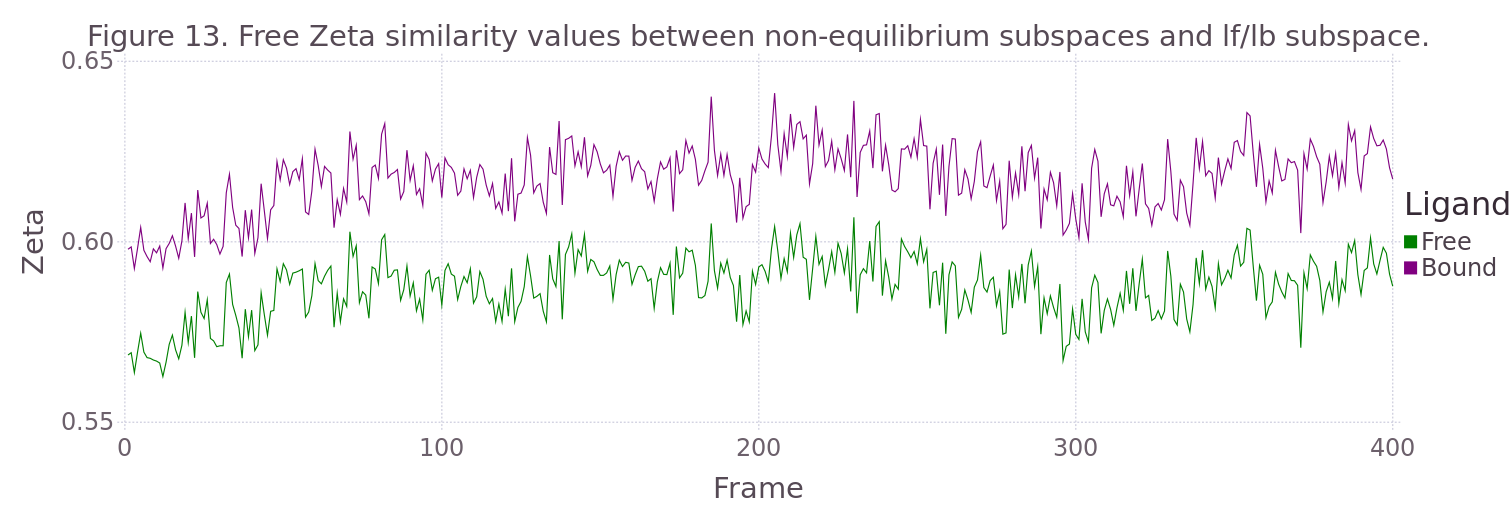

In [55]:
# Compila todo en un dataframe
df_gramm_neq_lf_lb = DataFrame(Zeta = [ gramm_lf_neq; gramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_gramm_neq_lf_lb = plot(df_gramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 13. Free Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"green", colorant"purple"),
Theme(grid_line_width=1pt, 
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

In [ ]:
# Compila todo en un dataframe
df_gramm_neq_lf_lb = DataFrame(Zeta = [ gramm_lf_neq; gramm_lb_neq ], Ligand = repeat(["Free"; "Bound"], inner = n_frames),
Frame = [ collect(1:n_frames) ; collect(1:n_frames)])

# Plot
pdf_gramm_neq_lf_lb = plot(df_gramm_neq_lf_lb, x="Frame", y="Zeta", color = "Ligand", Geom.line,
Guide.title("Figure 13. Weighted Zeta similarity values between non-equilibrium subspaces and lf/lb subspace."),
Scale.color_discrete_manual(colorant"green", colorant"purple"),
Theme( grid_line_width=1pt,
minor_label_font_size = 18pt, major_label_font_size = 22pt, key_title_font_size = 24pt,
key_label_font_size = 18pt))

In [67]:
tmp_matrix = lf_modes[:, 6] .* lb_modes[:, 8]
norm(tmp_matrix)

0.050734946203042156

In [68]:
gramm_lf_neq - gramm_lb_neq

400-element Array{Float64,1}:
 -0.0292969
 -0.0293133
 -0.0288243
 -0.0287349
 -0.0293187
 -0.0282193
 -0.0279962
 -0.0267585
 -0.0307926
 -0.0299932
 -0.0323972
 -0.0300587
 -0.0314622
  ⋮        
 -0.0282779
 -0.0290927
 -0.0317256
 -0.0316696
 -0.030752 
 -0.034738 
 -0.0355077
 -0.0318805
 -0.0297374
 -0.0288681
 -0.0294686
 -0.029712 